In [1]:
%matplotlib notebook

This notebook contains example code to regrid a flat binary file of Arctic Ocean region mask in NSIDC's North Polar Stereographic projection to a 50 km EASE grid using rasterio.  The rasterio regridding is based on gdal.

The notebook, if run on my windows machine, requires the base_rasterio environment.

In [8]:
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio.crs import CRS as rcrs
from rasterio import warp

import socket
import os

## Define image projection and parameters

Here I use Cartopy to define the projection.  An alternative approach, if you only want to reproject an image, would be to use rasterio.crs.CRS.from_string.  There is also a .from_epsg method.

The default ellipsoid is WGS84.  However, the NSIDC Polar Stereographic projection uses the Hugh's 1880 ellipsoid.  To account for this, a separate Globe object has to be created and passed to the Stereographic object.

In [3]:
src_proj = {'pixel_width': 25000,
            'pixel_height': 25000,
            'ccrs': {'central_latitude': 90.0,
                     'central_longitude': -45.0,
                     'false_easting': 0.0,
                     'false_northing': 0.0,
                     'true_scale_latitude': 70 },
            'bounds': [-3850000.000, 3750000., -5350000., 5850000.000]}
src_globe = ccrs.Globe(datum=None, semimajor_axis=6378273., semiminor_axis=6356889.449)

src_crs = ccrs.Stereographic(**src_proj['ccrs'], globe=src_globe)

## Define output projection and parameters

Similar to the Polar Stereographic projection, the version 1 EASE grid definition is not based on WGS84 but on a sphere.  This is defined using a Globe object.

In [4]:
dst_proj = {'pixel_width': 50135.05,
            'pixel_height': 50135.05,
            'ccrs': {'central_latitude': 90.,
                     'central_longitude': 0.,
                     'false_easting': 0.0,
                     'false_northing': 0.0},
            'bounds': [-8999241.475, 8999241.475, -8999241.475, 8999241.475]}
dst_globe = ccrs.Globe(datum=None, semimajor_axis=6371228, semiminor_axis=6371228)
dst_crs = ccrs.LambertAzimuthalEqualArea(**dst_proj['ccrs'], globe=dst_globe)
dst_size = (360, 360)

## Get mask file

In [11]:
def seaice_mask_path():
    dirpath = {'nsidc-abarrett': '/disks/sidads_ftp/DATASETS/NOAA/G02135/seaice_analysis',
               'barrett': r'C:\Users\apbarret\Documents\data\sea_ice_index'}
    return os.path.join(dirpath[socket.gethostname()],'Arctic_region_mask_Meier_AnnGlaciol2007.msk')

def read_seaice_mask(file=seaice_mask_path()):
    """Reads sea ice mask
    """
    cols = 304
    rows = 448
    img = np.fromfile(file, dtype='byte').reshape(rows, cols)
    return img

In [12]:
mask = read_seaice_mask()

## Plot mask file

<IPython.core.display.Javascript object>


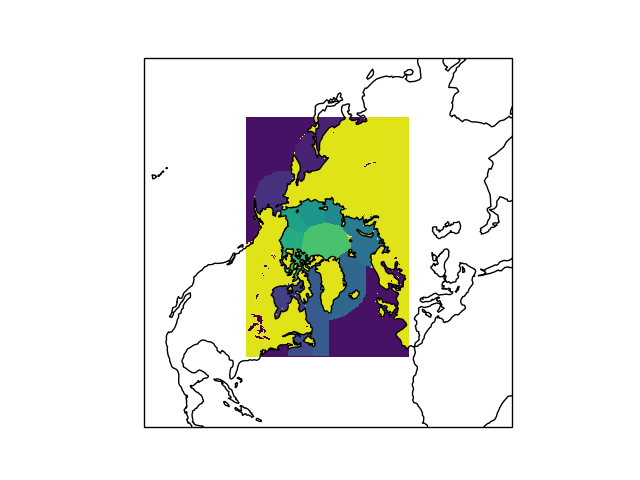

In [19]:
ax = plt.subplot(projection=src_crs)
ax.set_extent([0., 359., 20., 90.], ccrs.PlateCarree())
ax.imshow(mask, extent=src_proj['bounds'], origin='upper')
ax.coastlines()

## Reproject mask image

In [23]:
# Convert source and destination cartopy crs to rasterio crs
src_rcrs = rcrs.from_string(src_crs.proj4_init)
#src_rcrs = rcrs.from_string('+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 +units=m +no_defs')

dst_rcrs = rcrs.from_string(dst_crs.proj4_init)
#dst_rcrs = rcrs.from_string('+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +a=6371228 +b=6371228 +units=m +no_defs')

# Get shape of source grid
source_height, source_width = mask.shape

# Define source affine transformation
src_transform = rasterio.Affine(src_proj['pixel_width'], # pixel width
                                0.,                      # row rotation
                                src_proj['bounds'][0],   # Left coordinate
                                0.,                      # Column rotation
                                -1*src_proj['pixel_height'], # pixel height
                                src_proj['bounds'][3])

# Define destination affine transformation
dst_transform = rasterio.Affine(dst_proj['pixel_width'], # pixel width
                                0.,                      # row rotation
                                dst_proj['bounds'][0],   # Left coordinate
                                0.,                      # Column rotation
                                -1*dst_proj['pixel_height'], # pixel height
                                dst_proj['bounds'][3])

# Initialize destination array
dst = np.empty(dst_size, dtype=float)

# Do reprojection
warp.reproject(source=mask.astype(float),
               src_crs=src_rcrs,
               src_nodata=np.nan,
               src_transform=src_transform,
               destination=dst,
               dst_transform=dst_transform,
               dst_crs=dst_rcrs,
               dst_nodata=np.nan,
               SOURCE_EXTRA=0,
               resampling=warp.Resampling.nearest)


In [24]:
rasterio.__version__

'0.36.0'

## Plot result

<IPython.core.display.Javascript object>


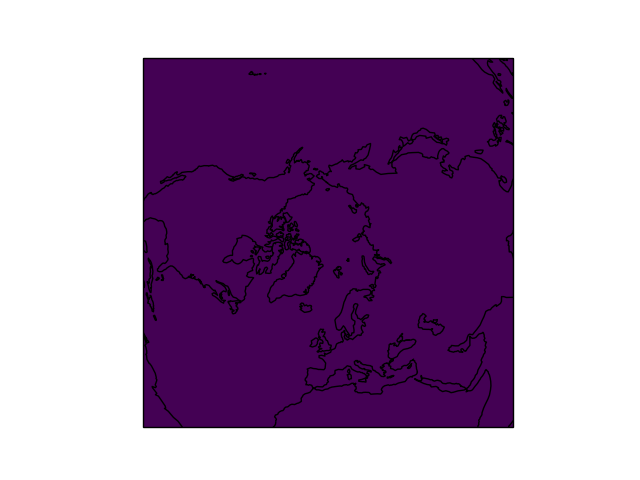

In [21]:
ax2 = plt.subplot(projection=dst_crs)
ax2.set_extent([0., 359., 20., 90.], ccrs.PlateCarree())
ax2.imshow(dst, extent=dst_proj['bounds'], origin='upper')
ax2.coastlines(zorder=3)

## Write result to GeoTiff file

In [77]:
outfile = 'Arctic_region_mask_Meier_AnnGlaciol2007_Nh50km.tif'
with rasterio.open(outfile, 'w', driver='GTiff', height=dst.shape[0],
                   width=dst.shape[1], count=1, dtype=str(dst.dtype),
                   crs=src_rcrs, transform=dst_transform) as destination_out:
    destination_out.write(dst, 1)